## Amsterdam Data API Analysis

This analysis uses public data accessible from the [Amsterdam Gemente Data API](https://api.data.amsterdam.nl/v1/docs/index.html). Data from the Containers and Weighing datasets are cleaned in Pandas and then visualized using Matplotlib. These datasets represent nodes in the Amsterdam waste system. A container is a recepticle for disposing of household waste. Multiple containers are grouped in clusters.

In [1]:
import csv
import time
import datetime
import requests
import warnings
import matplotlib
import waste_creds
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import json_normalize
from matplotlib.dates import DateFormatter

pd.options.mode.chained_assignment = None

## Data Gathering

The data was accessed using the python ``requests`` library. Requests allows you to access html elements of web pages and therefore to make calls to APIs to return data. The data is returned in JSON format and then normalized using the ``pandas`` ``json_normalize`` function so it is in a tabular format. With each request a new url is returned which allows for the results to be paged through. This code uses a ``while`` loop to loop through each url until there is no more left and all the data is accessed. With each iteration the normalised data is saved to a csv file.

In [ ]:
url = "https://api.data.amsterdam.nl/v1/huishoudelijkafval/container/"
response = requests.get(url)
data = response.json()
df = json_normalize(data['_embedded']['container'])
df.to_csv("container.csv")
while True:
    url = data['_links']['next']['href']
    response = requests.get(url)
    if response.status_code == 500:
        break
    data = response.json()
    df = json_normalize(data['_embedded']['container'])
    df.to_csv("container.csv", mode="a", index=False, header=False)

## Data Cleaning

The data is cleaned in a number of steps. First missing values pertinent to the analyses and duplciate rows are located and dealt with. A variable with confusing categories is then cleaned using a function. Further cleaning particular to each analysis comes later. 

In [2]:
containerlocatie = pd.read_csv("containerlocatie.csv") # Load the datasets
container = pd.read_csv("container.csv")
weighing = pd.read_csv("weighing-1.csv", low_memory = False)

In [3]:
container.info() # Info provides a quick way to understand what variables are in the dataset. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               2000 non-null   float64
 1   idNummer                         2000 non-null   object 
 2   serienummer                      2000 non-null   object 
 3   clusterId                        1451 non-null   object 
 4   eigenaarId                       2000 non-null   float64
 5   eigenaarNaam                     2007 non-null   object 
 6   status                           2007 non-null   int64  
 7   fractieCode                      1999 non-null   float64
 8   fractieOmschrijving              2006 non-null   object 
 9   datumCreatie                     2007 non-null   object 
 10  datumPlaatsing                   2007 non-null   object 
 11  datumOperationeel                1762 non-null   object 
 12  datumAflopenGarantie

In [4]:
container.isnull().sum() # An overview of the NA values in the data frame.

id                                    7
idNummer                              7
serienummer                           7
clusterId                           556
eigenaarId                            7
eigenaarNaam                          0
status                                0
fractieCode                           8
fractieOmschrijving                   1
datumCreatie                          0
datumPlaatsing                        0
datumOperationeel                   245
datumAflopenGarantie                169
datumOplevering                      12
wijzigingsdatumDp                     7
verwijderdDp                          7
geadopteerdInd                        7
locatieId                            42
typeId                                7
bagHoofdadresVerblijfsobjectId      556
gbdBuurtId                           42
bagOpenbareruimteId                 556
bagNummeraanduidingId               556
containerRalKleurNaam              1732
containerRalKleurCode              1732


We can use subsetting to find the rows where there is missing values and investigate. In this instance I searched online and found another dataset [here](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.tenderned.nl/papi/tenderned-rs-tns/v2/publicaties/137453/documenten/3477312/content&ved=2ahUKEwjqt-GkjfSFAxUGhf0HHeEpD-gQFnoECBAQAQ&usg=AOvVaw2BGFiuPodIctx1MZz72fXb) (Careful, this link will automatically open the dataset) that shows the container is 'KCA' or Household Hazardous Waste. As this is not a category for the rest of the containers in the dataset I made the decision to remove the item. Other options for dealing with this missing data include...
- Gauge the quality of the secondary data I found (Which contains other 'KCA' waste containers) and integrate that data here.
- Make a decision about how the KCA category might map on to the categories of the fractieOmschrijving variable and recode it accordingly. 

In [5]:
container[container.fractieOmschrijving.isnull()]

,id,idNummer,serienummer,clusterId,eigenaarId,eigenaarNaam,status,fractieCode,fractieOmschrijving,datumCreatie,...,containerDatumWijziging,containerEndOfLife,containerEigenaarschap,containerEigenaarschapOpmerking,containerOpmerking,geometrie.type,geometrie.coordinates,Unnamed: 38,Unnamed: 39,Unnamed: 40
186,102244.0,blipvert,BATMP00002,NaN,184.0,Amsterdam Dump Locatie,0,NaN,NaN,13/04/2018,...,2018-10-24T00:00:00,NaN,Gehuurd,De klant huurt de container van Bammens,NaN,Point,"[118758.27028057116, 486566.1161405434]",NaN,NaN,NaN


In [6]:
container = container[~container.fractieOmschrijving.isnull()] # Remove the row with NA values.

In [7]:
def cleaner(x):
    if 'Amsterdam Dump Locatie' in x:
        return('Amsterdam Dump')
    else:
        return(x.split(' ')[1])

In [8]:
container['eigenaarNaam'] = container.eigenaarNaam.apply(lambda x: cleaner(x))

## Bar Chart of Containers per District

In [9]:
count_data = container.groupby('eigenaarNaam')['fractieOmschrijving'].value_counts().unstack(fill_value=0)

In [10]:
count_data

fractieOmschrijving,Glas,Papier,Plastic,Rest,Textiel
eigenaarNaam,,,,,
Amsterdam,0,1,0,10,0
Amsterdam Dump,76,88,13,422,6
Centrum,3,6,0,6,1
Nieuw-West,42,103,1,249,6
Noord,21,45,0,91,0
Oost,41,60,0,231,7
West,19,29,1,233,5
Zuid,4,3,0,66,1
Zuidoost,22,28,0,62,4


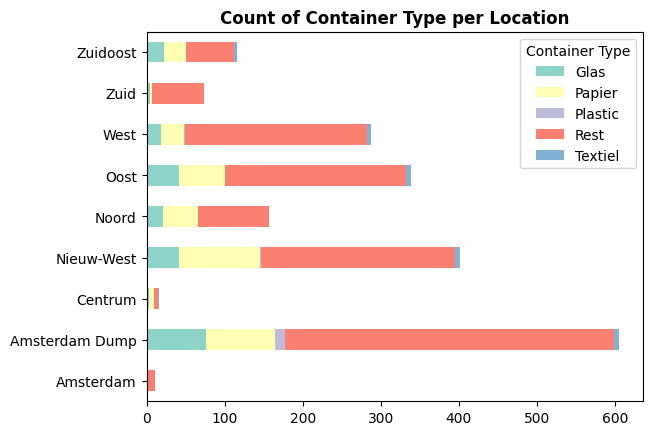

In [11]:
count_data.plot(kind='barh', stacked=True, color=['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of Container Type per Location', weight = 'bold')
plt.legend(title='Container Type')
plt.show()

## Bar Chart of Active and Inactive Containers

There are a *very* small number of containers that are not inactive or active but rather ready to go active. Only 4 containers of this status exist in Stadswerken. I removed these as they make the visual more clear. In a presentation setting however when presenting this visualization it would be important to mention that these also exist and how they might relate to the findings being presented. 

In [12]:
count_data2 = container[container.status != 2]

In [13]:
count_data2 = count_data2.groupby('eigenaarNaam')['status'].value_counts().unstack(fill_value=0)

In [14]:
count_data2

status,0,1
eigenaarNaam,,
Amsterdam,5,6
Amsterdam Dump,605,0
Centrum,0,16
Nieuw-West,12,389
Noord,5,149
Oost,11,328
West,10,277
Zuid,1,73
Zuidoost,1,115


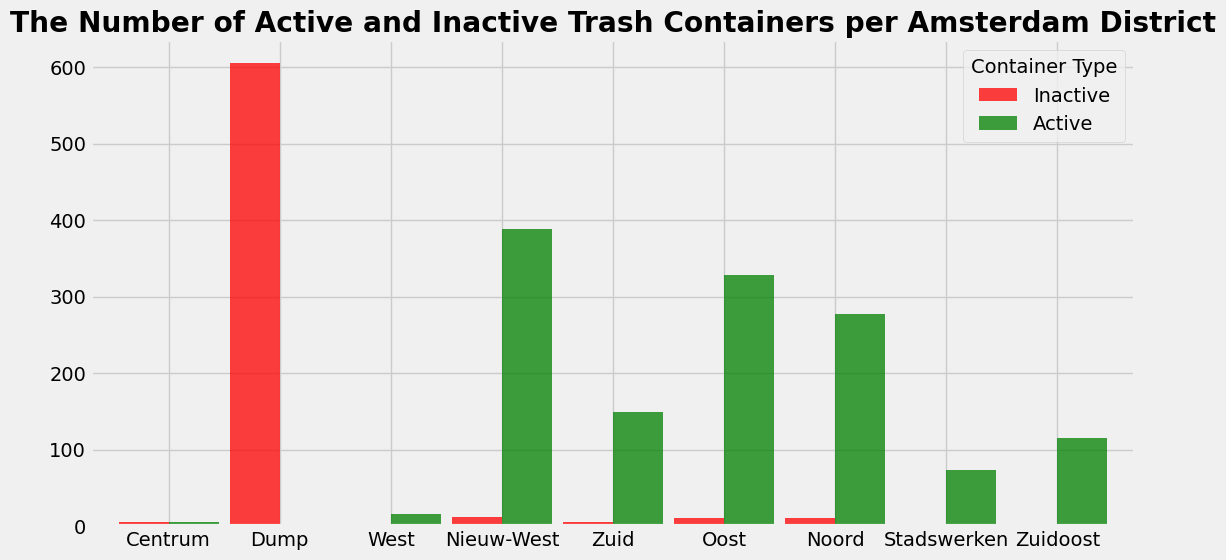

In [15]:
matplotlib.style.use('fivethirtyeight')
count_data2.plot(kind='bar', stacked=False, zorder = 2, width = 0.9, alpha = 0.75, color = ['r', 'g'])
plt.grid(axis='y', zorder=1)
plt.xlabel('')
plt.ylabel('')
plt.title('The Number of Active and Inactive Trash Containers per Amsterdam District', weight = 'bold')
plt.legend(title='Container Type', labels = {'Inactive': 0, 'Active': 1, 'Scheduled': 2})
plt.xticks(ticks=range(len(count_data2.index)), labels=['Centrum', 'Dump', 'West', 'Nieuw-West', 'Zuid', 'Oost', 'Noord',
          'Stadswerken', 'Zuidoost'], rotation = 0)
plt.gcf().set_size_inches(12, 6)
plt.show()

## Table of Container Lifespan per District

There are a lot of missing values in the ``datumOperationeel`` and the ``datumAflopenGarantie`` variables, but when we investigate virtually all of these are from inactive containers. Therefore this variable can still be used for analyses involving only active containers (albeit with the loss of 12 data points). 

In [16]:
container[container.datumOperationeel.isna()].status.value_counts()

0    240
2      3
1      1
Name: status, dtype: int64

In [17]:
container[container.datumAflopenGarantie.isna()].status.value_counts()

0    160
1      5
2      3
Name: status, dtype: int64

In [18]:
lifecycle = container[(~container.datumOperationeel.isna()) & (~container.datumAflopenGarantie.isna()) & (container.status != 0)]

In [19]:
date_format = "%d/%m/%Y"

In [20]:
lifecycle['datumOperationeel'] = lifecycle.datumOperationeel.apply(lambda x: datetime.strptime(x, date_format))
lifecycle['datumAflopenGarantie'] = lifecycle.datumAflopenGarantie.apply(lambda x: datetime.strptime(x, date_format))

In [21]:
lifecycle.datumOperationeel.dtype # Succesfully converted to a datetime

dtype('<M8[ns]')

In [22]:
lifecycle['difference'] = (lifecycle.datumOperationeel - lifecycle.datumAflopenGarantie).abs() # Find the difference in days
lifecycle['difference'] = lifecycle.difference.apply(lambda x: x.days)
lifecycle['difference'] = lifecycle['difference'].values.astype(int)

In [23]:
grouped_mean = lifecycle.groupby('eigenaarNaam')['difference'].mean().round(2).reset_index().rename(columns = {"eigenaarNaam": "District", 
                                                                                                               "difference": "Avg. Container Lifespan in Years"})
grouped_mean.set_index('District', inplace=True)
grouped_mean['Avg. Container Lifespan in Years'] = (grouped_mean['Avg. Container Lifespan in Years'] / 365).round(2)
grouped_mean

,Avg. Container Lifespan in Years
District,
Amsterdam,4.19
Centrum,6.03
Nieuw-West,6.62
Noord,6.26
Oost,3.99
West,6.62
Zuid,6.61
Zuidoost,5.84


## Linegraph with Cumulative Count of Active Containers

There are several containers whose location is not more specific than merely Amsterdam. Like previously we could attempt to locate this data in another database and find a more specific location. For now, in this visualization, they are not included. 

In [24]:
lifecycle = lifecycle[~(lifecycle.eigenaarNaam == 'Amsterdam')]

This visualization shows the cumulative count of active containers in the dataset in each location over a 5 year period. 

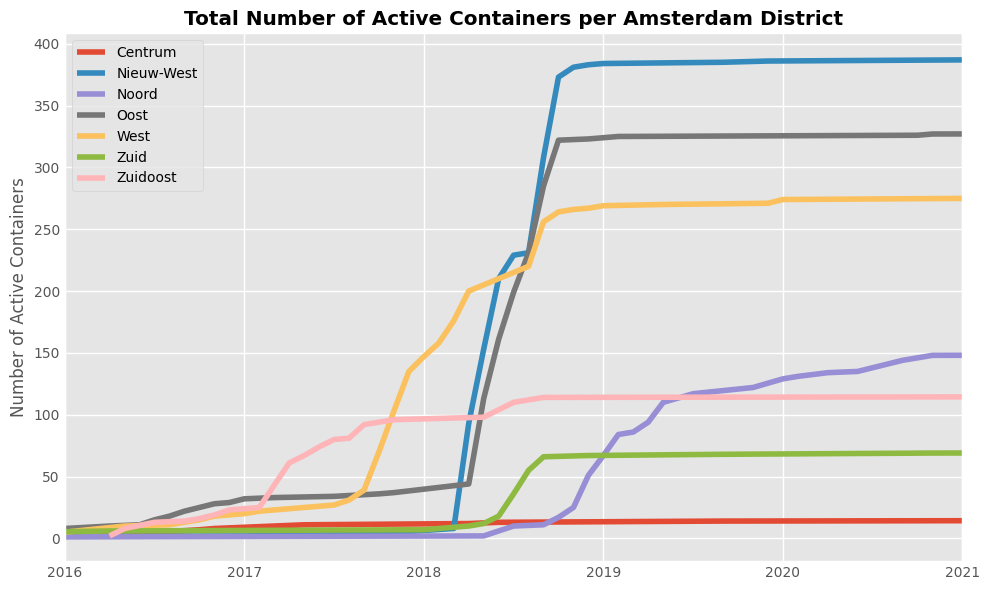

In [25]:
matplotlib.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
for category, data in lifecycle.groupby('eigenaarNaam'):
    data.groupby(data['datumOperationeel'].dt.to_period('M')).size().cumsum().plot(ax=ax, label=category)
ax.set_xlim(pd.Timestamp('2016-01-01'), '2021-01-01')
ax.set_title('Total Number of Active Containers per Amsterdam District', weight = 'bold')

ax.set_xlabel('')
ax.set_ylabel('Number of Active Containers')
ax.legend()
fig.tight_layout()
plt.show()

## Single Container Weight Visualization

By joining data from multiple datasets we can make even more fine-grained analyses. The following code creates a visualization of one cluster of containers in Amterdam Nieuw-West. 

In [26]:
container_b = container.copy() # Create copies of the original data
weighing_b = weighing.copy()

In [27]:
container_b.rename(columns = {'idNummer' : 'volgnummer'}, inplace = True) # Rename a column for merging.

In [28]:
container_b['volgnummer'] = container_b['volgnummer'].astype(str) # Make sure the columns to be merged on are the same type. 
weighing_b['volgnummer'] = weighing_b['volgnummer'].astype(str)

The serial number in the container table is slightly different from the one in the weighing table. The former contains a 3 character code before a string of numbers, the latter contains only the number part. To effectively merge the two then, the character part is stripped from the container table. 

In [29]:
container_b['volgnummer'] = container_b.volgnummer.apply(lambda x: x[3:])

In [30]:
weighing_b = weighing_b[['volgnummer', 'datumWeging', 'nettoGewicht']] # Retain only the columns needed for the visualization.
container_b = container_b[['volgnummer', 'fractieOmschrijving', 'clusterId']]

In [31]:
final_df = weighing_b.merge(container_b, on = 'volgnummer', how = 'left') # Join the data.

In [32]:
final_df = final_df[final_df.clusterId == '115203.340|487447.413']

In [34]:
with warnings.catch_warnings(): # Convert to a datetime and ignore the warnings. 
    warnings.simplefilter("ignore")
    final_df.datumWeging = pd.to_datetime(final_df.datumWeging)

In [35]:
grouped_data = final_df.groupby([final_df.datumWeging.dt.year, final_df.fractieOmschrijving])['nettoGewicht'].sum().reset_index()
grouped_data = pd.DataFrame(grouped_data)

In [36]:
grouped_data['fractieOmschrijving'] = grouped_data.fractieOmschrijving.map({'Rest' : 'Rest', 'Papier': 'Paper', 'Glas': 'Glass'})

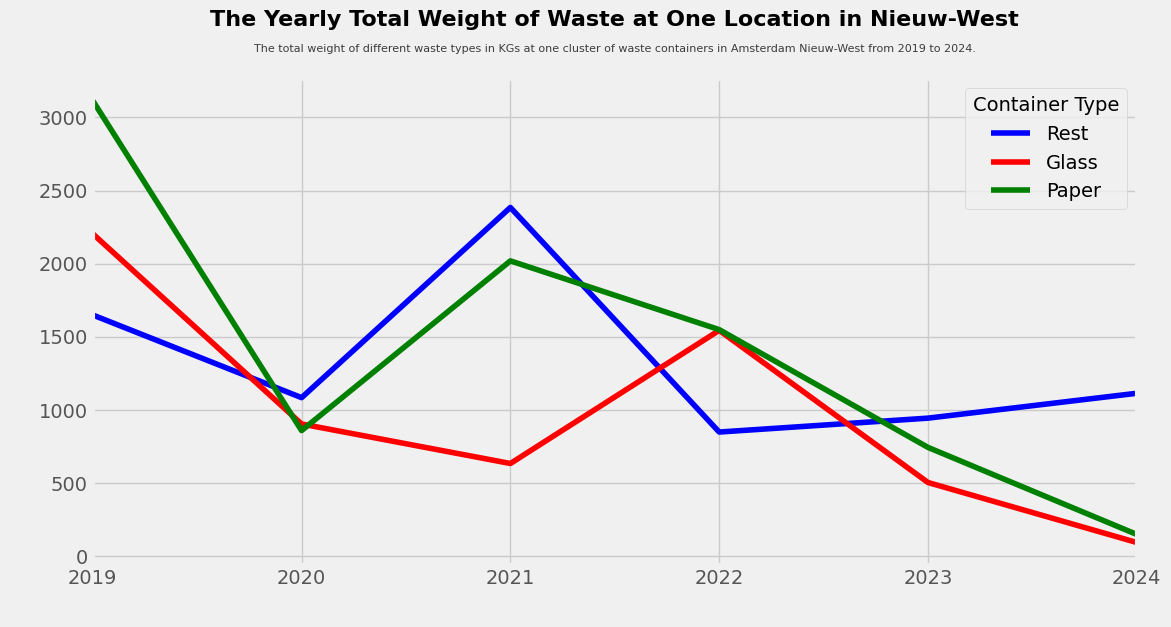

In [37]:
matplotlib.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='datumWeging', 
             y='nettoGewicht',
             hue='fractieOmschrijving', 
             palette=['b','r', 'g'],
             data=grouped_data)
ax.set(xlim=(2019, 2024))
plt.legend(title='Container Type', loc='upper right')
ax.text(x=0.5, y=1.1, s='The Yearly Total Weight of Waste at One Location in Nieuw-West', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='The total weight of different waste types in KGs at one cluster of waste containers in Amsterdam Nieuw-West from 2019 to 2024.', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()